# Рекомендация тарифов для оператора мобильной связи

## Описание проекта
Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».
В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — её уже сделали.
Необходимо построить модель с максимально большим значением accuracy (не менее 0,75).

## План работы
* Загрузка и подготовка данных
* Исследование качества различных моделей
* Проверка качества выбранной модели
* Проверка модели на адекватность

## Загрузка и подготовка данных

In [1]:
# Импорты
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier

In [2]:
# Загрузка данных
try:
    original_df = pd.read_csv('/datasets/users_behavior.csv')
    print('Данные из Практикума загружены.')
except:
    original_df = pd.read_csv('datasets/users_behavior.csv')
    print('Локальные данные загружены.')

display('Размеры загруженного датафрейма:')
original_df.shape

Локальные данные загружены.


'Размеры загруженного датафрейма:'

(3214, 5)

### Описание данных
`сalls` — количество звонков
`minutes` — суммарная длительность звонков в минутах
`messages` — количество sms-сообщений
`mb_used` — израсходованный интернет-трафик в Мб
`is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0)

In [3]:
# Изучим данные
display('Голова:', original_df.head())
display('Хвост:', original_df.tail())
display('Инфо:')
original_df.info()

'Голова:'

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


'Хвост:'

,calls,minutes,messages,mb_used,is_ultra
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0
3213,80.0,566.09,6.0,29480.52,1


'Инфо:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


**Выводы:**
* Необходимо преобразовать calls и messages в int64.
* Пропусков нет, столбцы поименованы корректно.

### Подготовка данных

In [4]:
# Создаём рабочую копию датафрейма
df = original_df.copy()

In [5]:
# Проверим наличие дубликатов
df.duplicated().sum()

0

In [6]:
# Проверим наличие дубликатов в фича-сете
df.drop(columns='is_ultra').duplicated().sum()

0

In [7]:
# Замена типов
df[['calls', 'messages']] = df[['calls', 'messages']].astype('int64')
df.dtypes

calls         int64
minutes     float64
messages      int64
mb_used     float64
is_ultra      int64
dtype: object

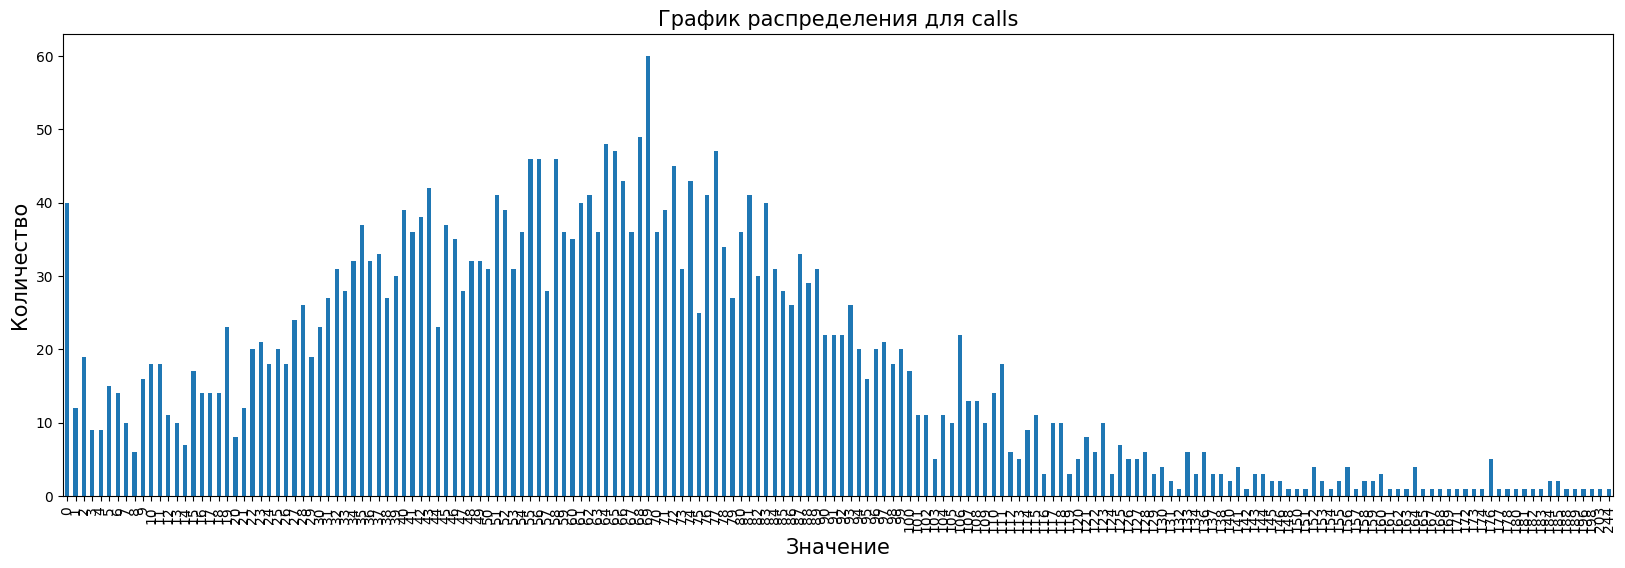

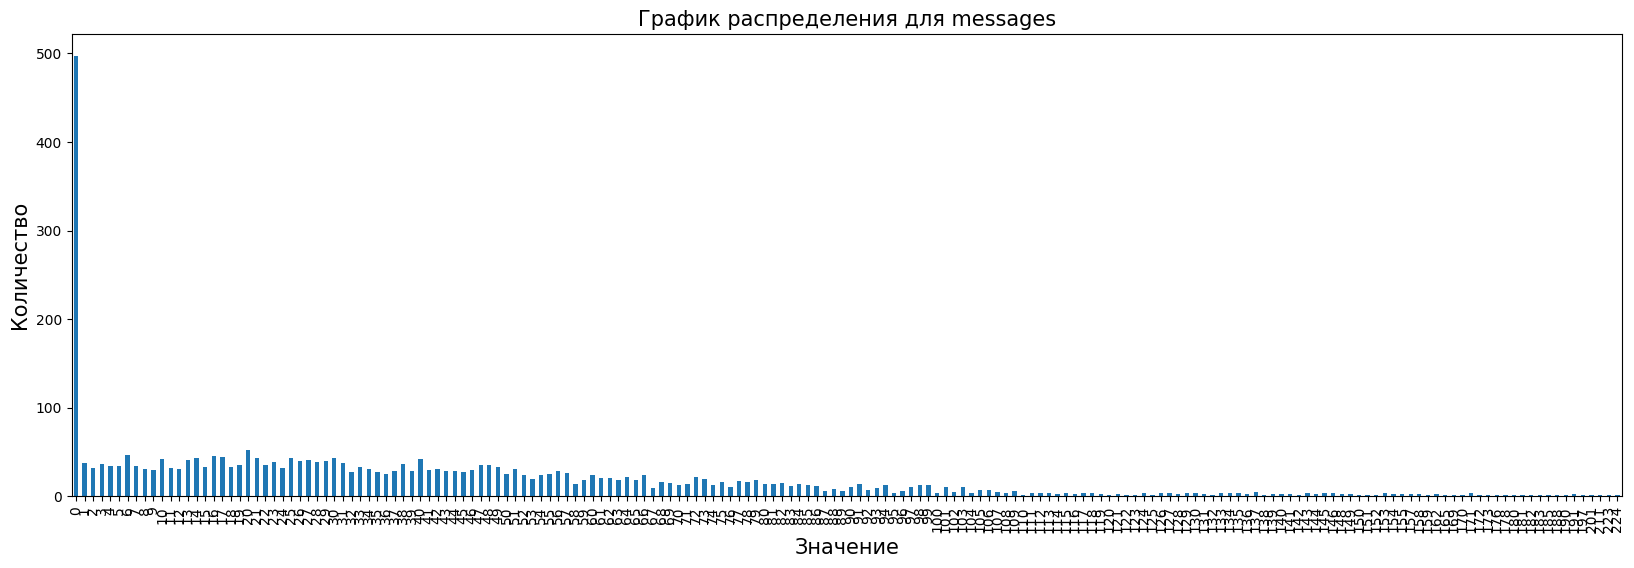

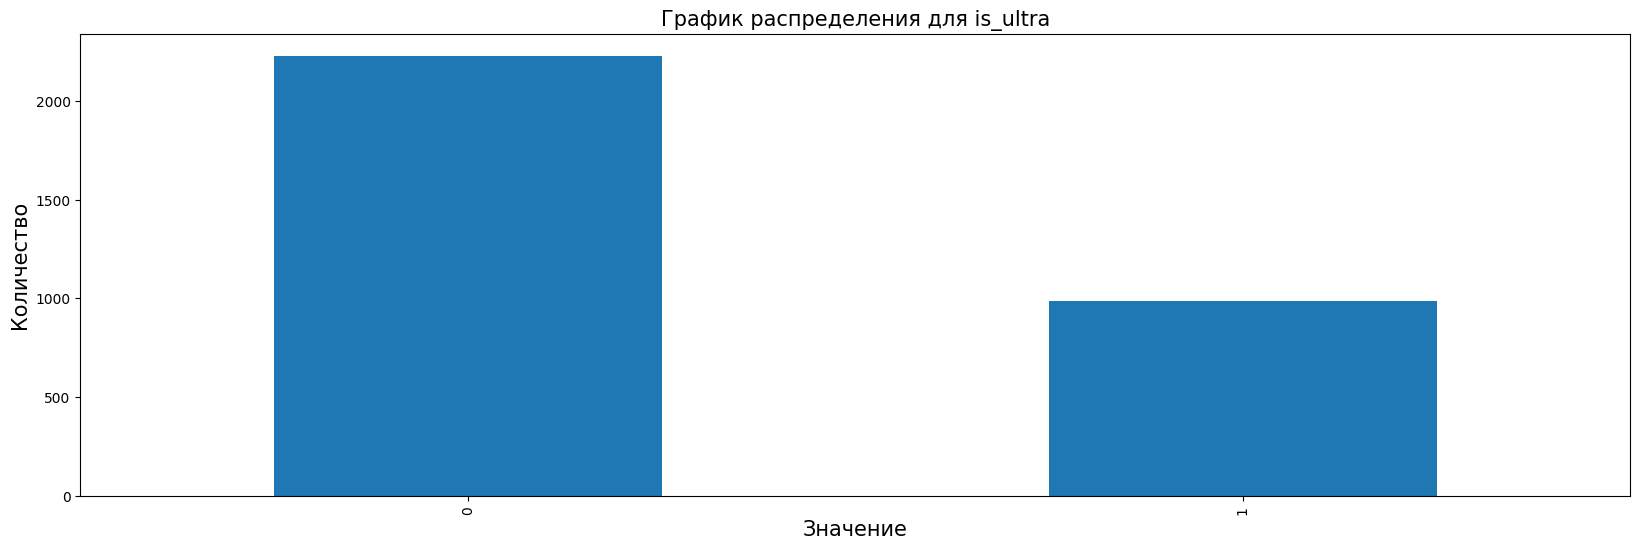

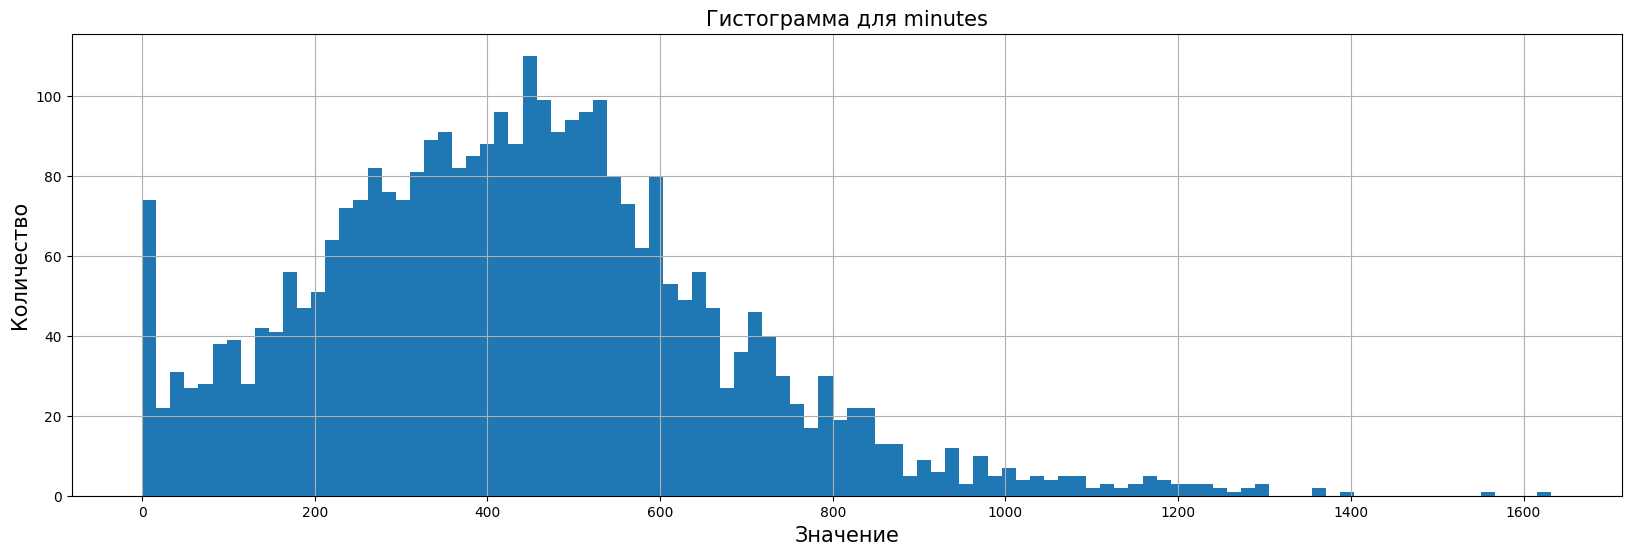

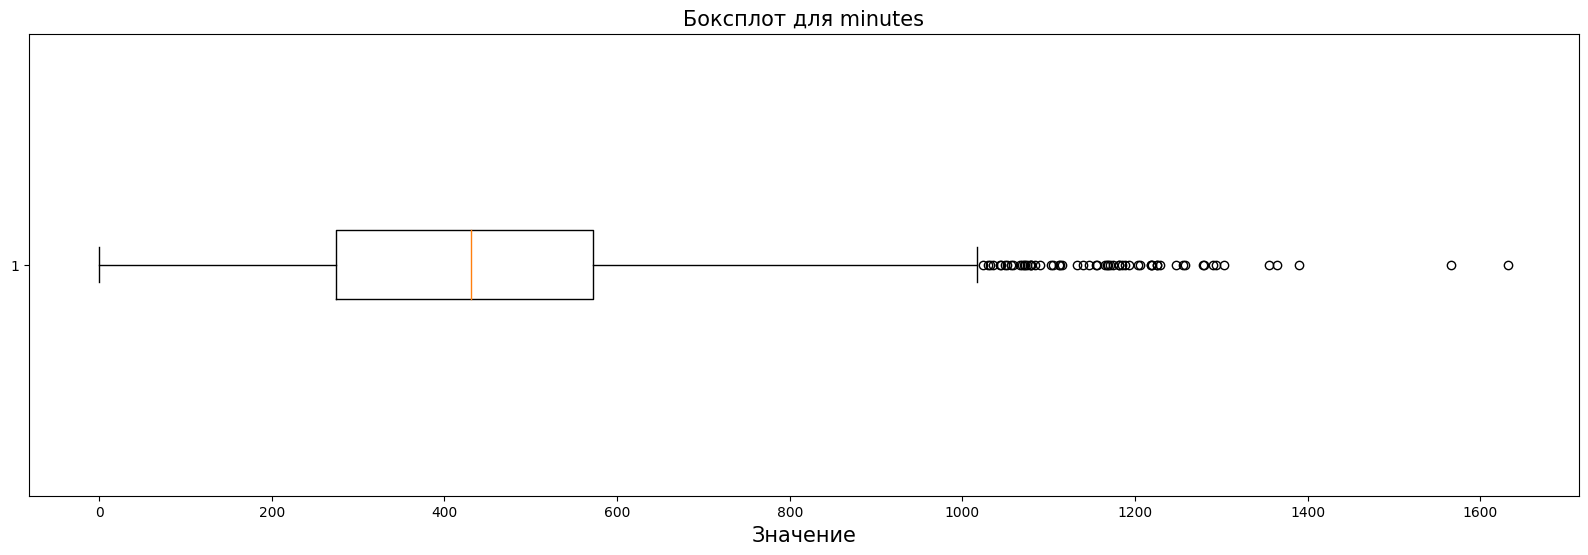

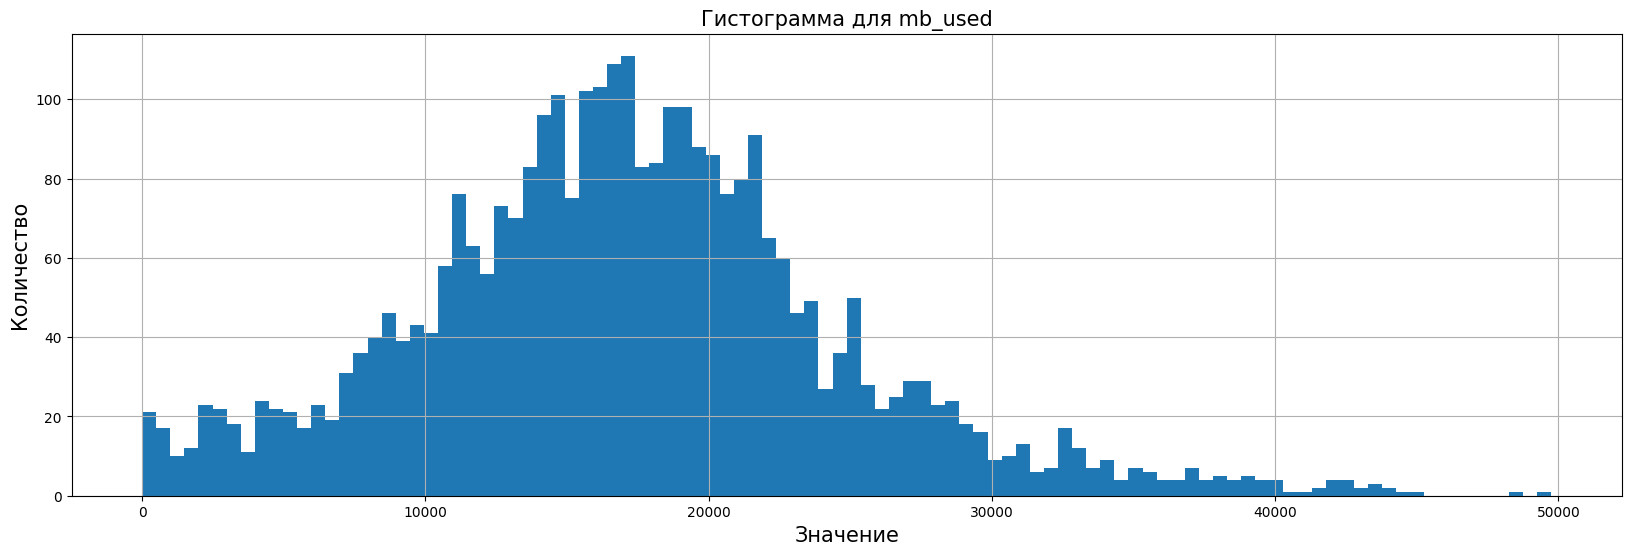

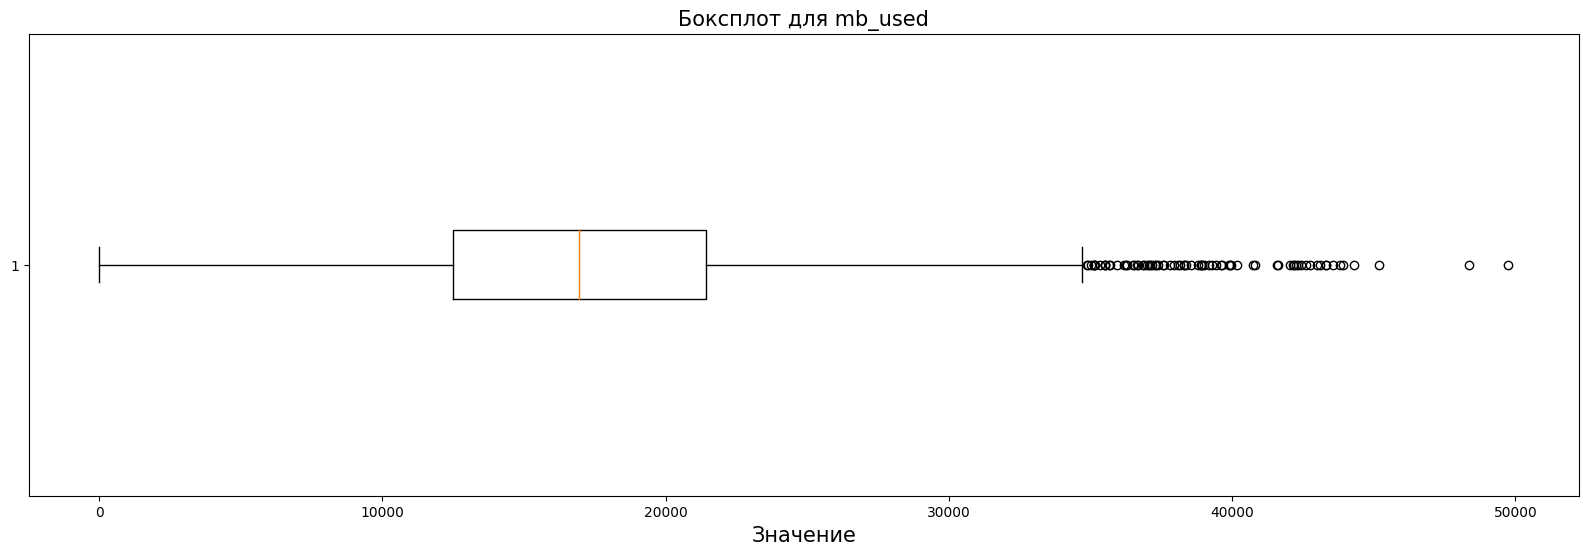

In [8]:
# Посмотрим на графики распределения по столбцам
for column in df.select_dtypes(include='int64').columns:
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.set_title(f'График распределения для {column}', fontsize=15)
    ax.set_xlabel('Значение', fontsize=15)
    ax.set_ylabel('Количество', fontsize=15)
    df[column].value_counts().sort_index().plot(kind='bar', ax=ax)

for column in df.select_dtypes(include='float64').columns:
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.set_title(f'Гистограмма для {column}', fontsize=15)
    ax.set_xlabel('Значение', fontsize=15)
    ax.set_ylabel('Количество', fontsize=15)
    df[column].hist(bins=100, ax=ax)

    fig, ax = plt.subplots(figsize=(20, 6))
    ax.set_title(f'Боксплот для {column}', fontsize=15)
    ax.set_xlabel('Значение', fontsize=15)
    plt.boxplot(x=df[column], vert=False);

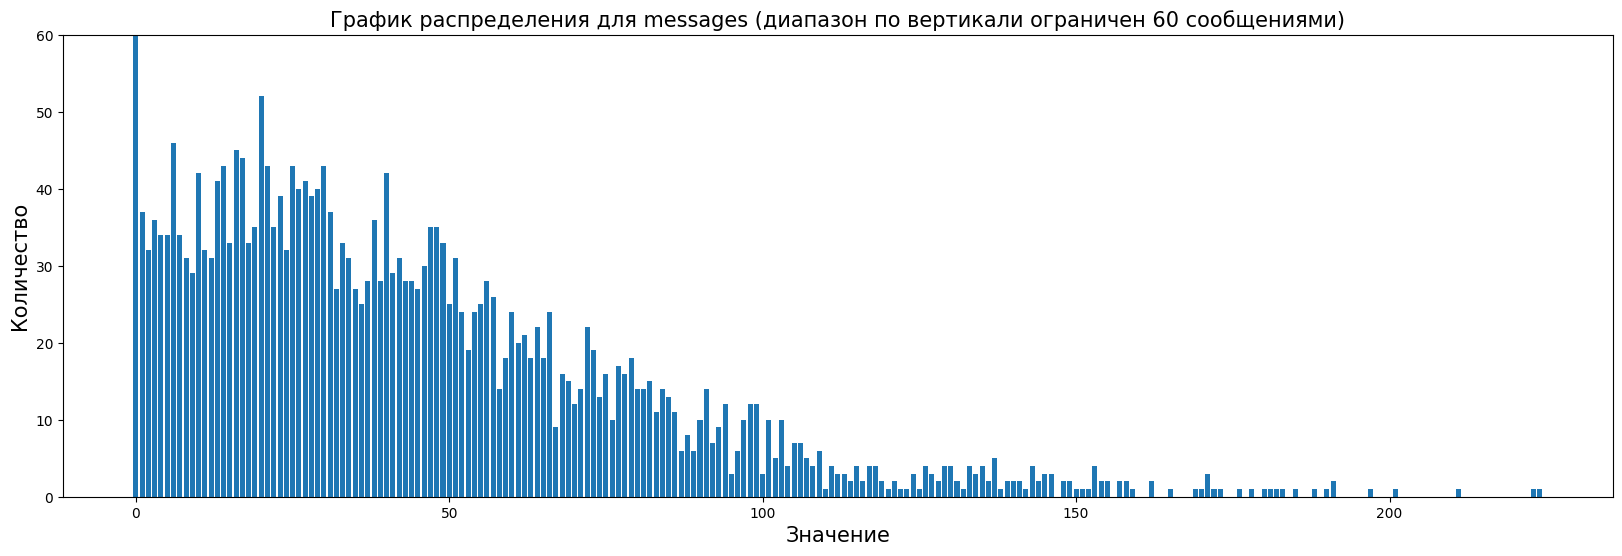

In [9]:
# Посмотрим более подробно на messages, ограничим график по вертикали
fig, ax = plt.subplots(figsize=(20, 6))
ax.set_title(f'График распределения для messages (диапазон по вертикали ограничен 60 сообщениями)', fontsize=15)
ax.set_xlabel('Значение', fontsize=15)
ax.set_ylabel('Количество', fontsize=15)
plt.ylim(0, 60)
ax.bar(df['messages'].value_counts().reset_index(drop=False)['index'],
       df['messages'].value_counts().reset_index(drop=False)['messages']);

In [10]:
# Распределение пользователей по тарифам в относительных цифрах
df['is_ultra'].value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

**Выводы:**
* По графикам видим "выбросы" по `calls`, `minutes` и `messages` в районе нуля. Это вполне объяснимо т.к. существует довольно большое количество пользователей, которые используют мобильную связь только для доступа в интернет (например сим-карта для планшета или умного дома). Еще больше людей не пользуется sms-сообщениями, т.к. эта технология общения устарела.
* По величинам `minutes` и `mb_used` имеются значения, выходящие за пределы усов боксплота, но обрезать их пока не будем. Эти значения, хоть и велики, но не выглядят ошибочными.
* Дубликатов в данных нет.
* Распределение целевого столбца: примерно 70% на 30% в пользу тарифа "Смарт".

### Выделение обучающей, валидационной и тестовой выборок

In [11]:
# Выделим фичасет и таргет
X = df.drop(columns='is_ultra')
y = df['is_ultra']
# Выделим train, dev и test сеты
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=777)
X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=777)
# Посмотрим на итоговые размеры датафреймов
display(X.shape, y.shape, X_train.shape, y_train.shape, X_dev.shape, y_dev.shape, X_test.shape, y_test.shape)

(3214, 4)

(3214,)

(1928, 4)

(1928,)

(643, 4)

(643,)

(643, 4)

(643,)

**Выводы:**
* Данные содержат 3214 строки, 4 фичи и 1 целевой столбец.
* Пропусков и выбросов в данных нет. Дубликатов в данных нет.
* Датасет разделен на train, dev и test в пропорции 60%-20%-20%.
* 30% целевого столбца содержат 1 (тариф ultra).

## Исследование качества различных моделей

**Модели для исследования:**
Проверим модели для классификации.
* LogisticRegression
* DecisionTreeClassifier
    * Изучим различные варианты глубины дерева
* RandomForestClassifier
    * Изучим различные варианты глубины дерева
    * Изучим различные варианты количества деревьев

In [12]:
# Создадим словарь для сохранения лучших результатов по моделям
best_results_by_model = {}

### LogisticRegression

In [13]:
# Модель логистической регрессии
model = LogisticRegression(max_iter=10 ** 6, random_state=777)
model.fit(X_train, y_train)
accuracy = model.score(X_dev, y_dev)
display(f'Точность на dev при использовании логистической регрессии {accuracy:0.2%}')
accuracy = model.score(X_train, y_train)
display(f'Точность на train при использовании логистической регрессии {accuracy:0.2%}')
# Сохраним результат
best_results_by_model['LR'] = accuracy

'Точность на dev при использовании логистической регрессии 72.63%'

'Точность на train при использовании логистической регрессии 76.14%'

**Выводы:**
* Модель логистической регрессии даёт точность на dev выборке в 72.63%. Это немногим больше, чем точность если просто предсказывать 0 всегда.
* При этом точность на train так же не очень высокая и составляет 76,14%, что говорит о недообучении (модель слишком простая для изучаемых данных - high bias).

### DecisionTreeClassifier

'Лучший результат по accuracy: 78.07%'

'Глубина дерева для лучшего результата: 10'

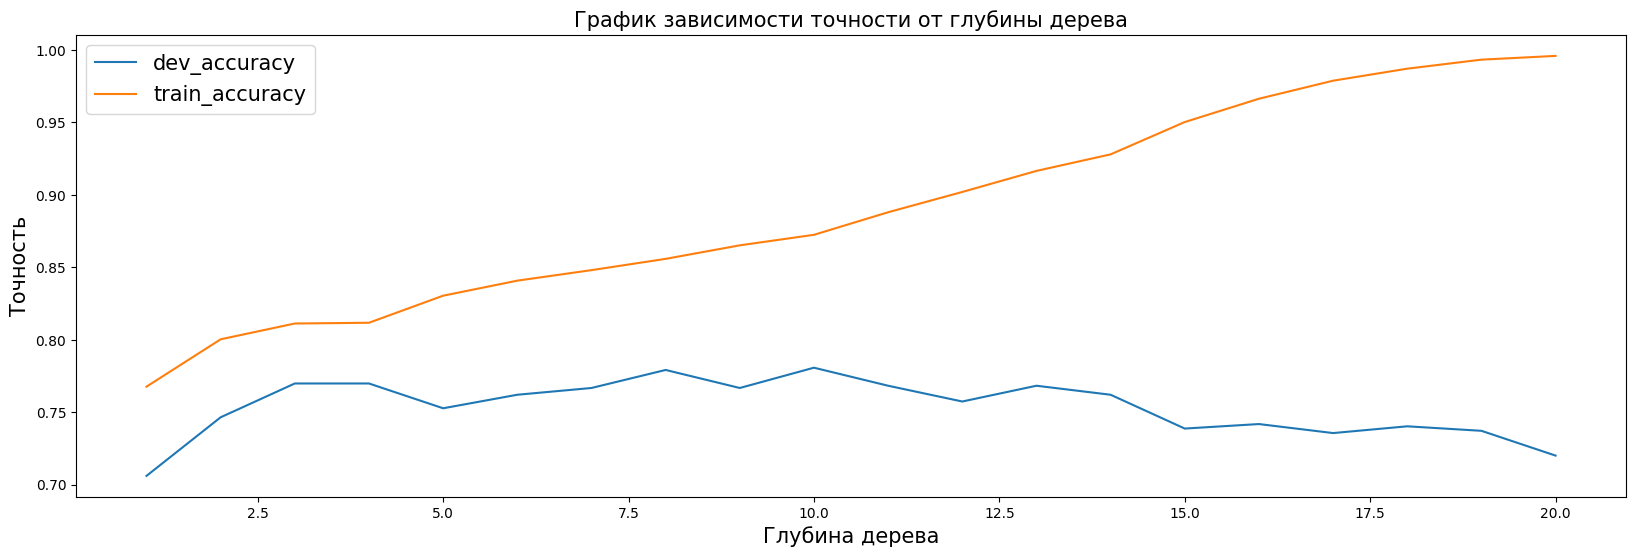

In [14]:
# Дерево
best_depth = None
best_accuracy = 0
depths = []
dev_accuracies = []
train_accuracies = []
# Перебор по глубине дерева
for depth in range(1, 21):
    model = DecisionTreeClassifier(max_depth=depth, random_state=777)
    model.fit(X_train, y_train)
    dev_accuracy = model.score(X_dev, y_dev)
    train_accuracy = model.score(X_train, y_train)
    depths.append(depth)
    dev_accuracies.append(dev_accuracy)
    train_accuracies.append(train_accuracy)
    if dev_accuracy > best_accuracy:
        best_depth = depth
        best_accuracy = dev_accuracy

# Построим зависимости accuracy по dev и train в зависимости от глубины дерева
fig, ax = plt.subplots(figsize=(20, 6))
ax.set_title('График зависимости точности от глубины дерева', fontsize=15)
ax.set_xlabel('Глубина дерева', fontsize=15)
ax.set_ylabel('Точность', fontsize=15)
ax.plot(depths, dev_accuracies, label='dev_accuracy')
ax.plot(depths, train_accuracies, label='train_accuracy')
ax.legend(fontsize=15)

display(f'Лучший результат по accuracy: {best_accuracy:.2%}')
display(f'Глубина дерева для лучшего результата: {best_depth}')

# Сохраним лучший результат
best_results_by_model[f'DTC, depth={best_depth}'] = best_accuracy

In [15]:
# Попробуем провести ряд экспериментов без фиксации random_state.
# Создадим сеты, чтобы получить результаты без повторений
depths = set()
dev_accuracies = set()
# Проведем эксперимент 100 раз
for _ in range(100):
    # Снова выделим train, dev и test сеты
    X_train_experimental, X_test_experimental, y_train_experimental, y_test_experimental = train_test_split(X, y,
                                                                                                            test_size=0.4)
    X_dev_experimental, X_test_experimental, y_dev_experimental, y_test_experimental = train_test_split(
        X_test_experimental, y_test_experimental, test_size=0.5)

    # Переменные для сохранения лучших результатов для нашей разбивки
    best_depth = None
    best_accuracy = 0

    # Обучим модели для разной глубины
    for depth in range(1, 21):
        model = DecisionTreeClassifier(max_depth=depth)
        model.fit(X_train_experimental, y_train_experimental)
        dev_accuracy = model.score(X_dev_experimental, y_dev_experimental)
        train_accuracy = model.score(X_train_experimental, y_train_experimental)
        if dev_accuracy > best_accuracy:
            best_depth = depth
            best_accuracy = dev_accuracy

    depths.add(best_depth)
    dev_accuracies.add(best_accuracy)

display(f'Варианты лучшей глубины дерева: {depths}')
display(f'Минимальная лучшая accuracy: {min(dev_accuracies):.2%}')
display(f'Максимальная лучшая accuracy: {max(dev_accuracies):.2%}')

'Варианты лучшей глубины дерева: {3, 4, 5, 6, 7, 8, 9, 10, 11}'

'Минимальная лучшая accuracy: 76.83%'

'Максимальная лучшая accuracy: 83.05%'

**Выводы:**
* В результате перебора различной глубины деревьев получен лучший результат по accuracy в размере 78,07%. Лучшая глубина при этом получилась равной 10.
* Стоит отметить, что модель может давать очень разнящиеся результаты по оптимальной глубине дерева в зависимости от random_state как в классификаторе, так и в методе train_test_split.
* На графике изменения dev и train accuracy в зависимости от глубины дерева так же видно, что несмотря на то, что пик находится при random_state=777 в районе 10, есть так же и другие локальные пики, близкие по точности в районе 3 и 8.
* Если же провести много итераций обучения без фиксации random_state, то итоговый результат может колебаться по глубине от 3 до 12, а итоговая лучшая точность в зависимости от глубины будет колебаться в пределах 76-82%. Такая нестабильность, вероятно, связана с недостаточно большим объемом примеров для обучения, либо с нестабильностью дерева решений как модели.
* Таким образом, проблематично выбрать оптимальную глубину DecisionTreeClassifier для представленных данных, но результаты по точности явно превосходят логистическую регрессию. Остановимся на max_depth=10.

### RandomForestClassifier

'Лучший результат по accuracy: 80.56%'

'Глубина дерева для лучшего результата: 15'

'Количество деревьев для лучшего результата: 13'

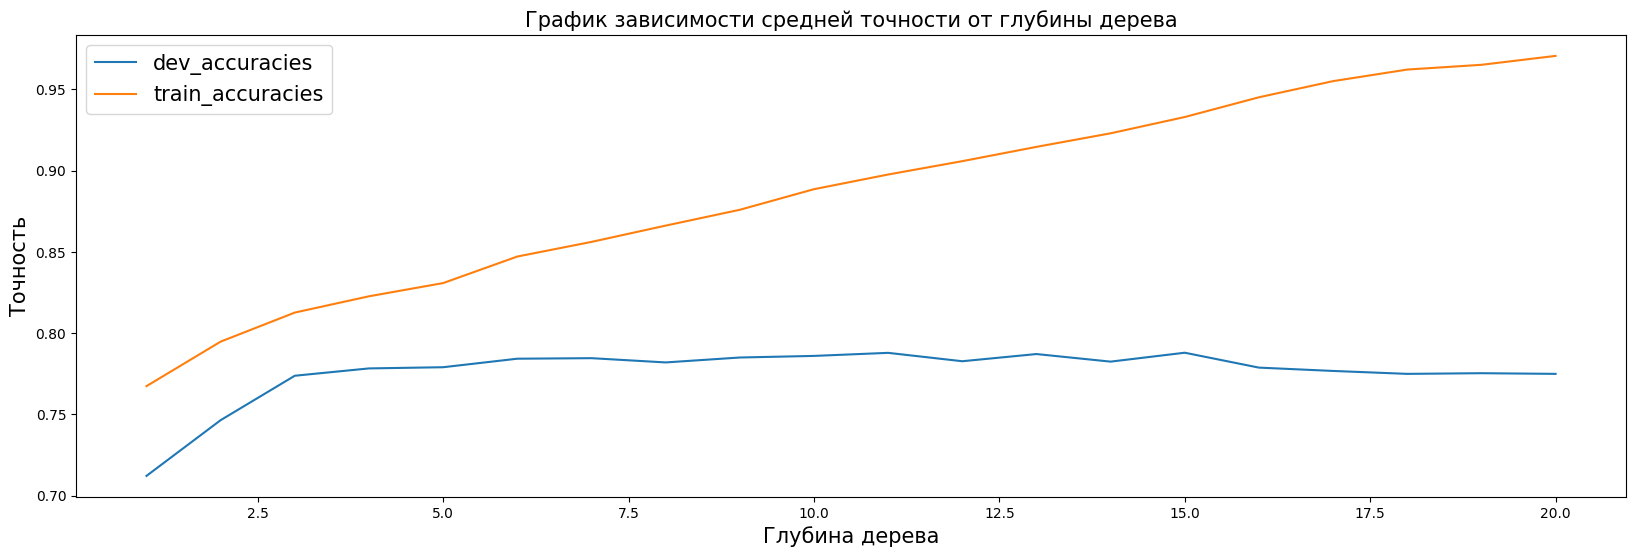

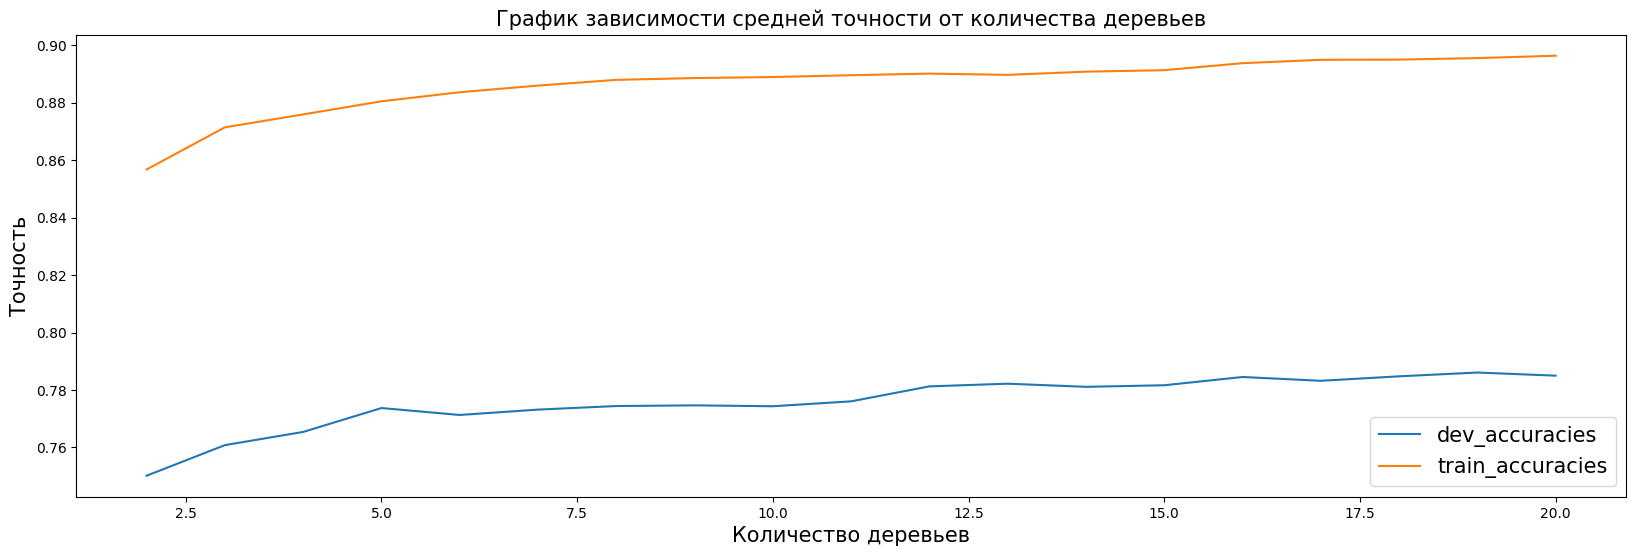

In [16]:
# Рандомные деревья
best_depth = None
best_tree_amount = None
best_model = None
best_accuracy = 0
depths = []
tree_amounts = []
dev_accuracies = []
train_accuracies = []
# Перебор по глубине дерева
for depth in range(1, 21):
    # Перебор по количеству деревьев
    for trees in range(2, 21):
        model = RandomForestClassifier(n_estimators=trees, max_depth=depth, random_state=777)
        model.fit(X_train, y_train)
        dev_accuracy = model.score(X_dev, y_dev)
        train_accuracy = model.score(X_train, y_train)
        depths.append(depth)
        tree_amounts.append(trees)
        dev_accuracies.append(dev_accuracy)
        train_accuracies.append(train_accuracy)
        if dev_accuracy > best_accuracy:
            best_depth = depth
            best_tree_amount = trees
            best_accuracy = dev_accuracy
            best_model = model

# Подготовим датафрейм для графиков
df_for_graphics = pd.DataFrame({'depths': depths, 'tree_amounts': tree_amounts, 'dev_accuracies': dev_accuracies,
                                'train_accuracies': train_accuracies})
# Рассчитаем средние accuracy для различных depths и tree_amounts
df_for_depths = df_for_graphics.groupby('depths')[['dev_accuracies', 'train_accuracies']].mean()
df_for_tree_amounts = df_for_graphics.groupby('tree_amounts')[['dev_accuracies', 'train_accuracies']].mean()

# Построим график средней accuracy по dev и train в зависимости от глубины дерева
fig, ax = plt.subplots(figsize=(20, 6))
ax.set_title('График зависимости средней точности от глубины дерева', fontsize=15)
ax.set_xlabel('Глубина дерева', fontsize=15)
ax.set_ylabel('Точность', fontsize=15)
ax.plot(df_for_depths)
ax.legend(df_for_depths.columns, fontsize=15)

# Построим график средней accuracy по dev и train в зависимости от количества деревьев
fig, ax = plt.subplots(figsize=(20, 6))
ax.set_title('График зависимости средней точности от количества деревьев', fontsize=15)
ax.set_xlabel('Количество деревьев', fontsize=15)
ax.set_ylabel('Точность', fontsize=15)
ax.plot(df_for_tree_amounts)
ax.legend(df_for_tree_amounts.columns, fontsize=15)

display(f'Лучший результат по accuracy: {best_accuracy:.2%}')
display(f'Глубина дерева для лучшего результата: {best_depth}')
display(f'Количество деревьев для лучшего результата: {best_tree_amount}')

# Сохраним лучший результат
best_results_by_model[f'RFC, depth={best_depth}, n_est={best_tree_amount}'] = best_accuracy

**Выводы:**
* В результате перебора различной глубины деревьев и различного их количества получен лучший результат по accuracy в размере 80,56%. Лучшая глубина при этом получилась равной 15, а количество деревьев составило 13 штук.
* Аналогично DecisionTreeClassifier мы видим, что подобрать однозначно оптимальные параметры довольно сложно. В зависимости от random_seed могут получаться различные комбинации оптимальных результатов. Но, как мы видим по графикам, в среднем, глубина дерева не должна быть меньше 3, а количество деревьев лучше установить в размере не менее 10.

## Проверка качества выбранной модели

'Лучшая модель: RFC, depth=15, n_est=13'

'Лучшая точность: 80.56%'

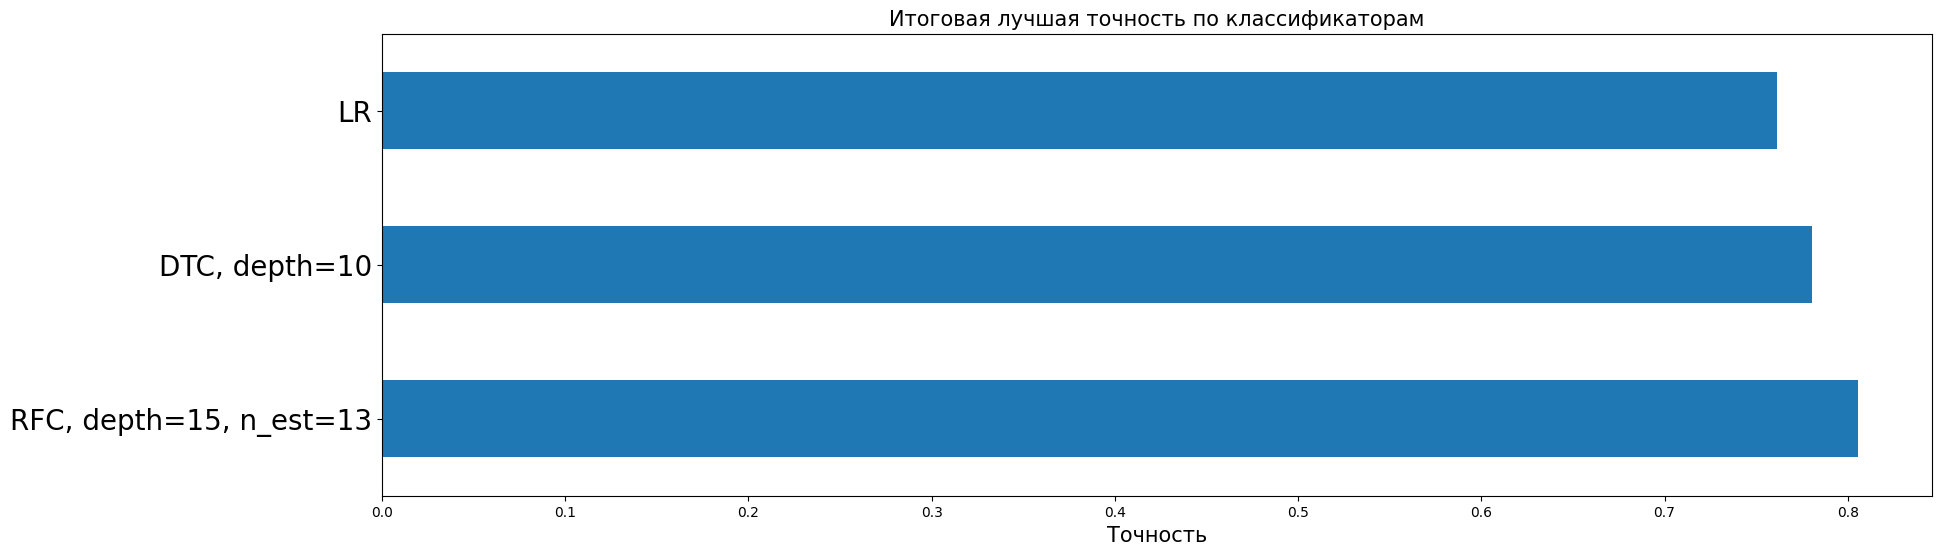

In [17]:
# Итог по моделям
best_results_by_model = pd.Series(best_results_by_model).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(20, 6))
ax.set_title('Итоговая лучшая точность по классификаторам', fontsize=15)
ax.set_xlabel('Точность', fontsize=15)
ax.tick_params(axis='y', which='both', labelsize=20)
best_results_by_model.plot(kind='barh')
display(
    f'Лучшая модель: {best_results_by_model[best_results_by_model == best_results_by_model.max()].index.tolist()[0]}')
display(
    f'Лучшая точность: {best_results_by_model[best_results_by_model == best_results_by_model.max()].tolist()[0]:.2%}')

In [18]:
best_results_by_model

RFC, depth=15, n_est=13    0.805599
DTC, depth=10              0.780715
LR                         0.761411
dtype: float64

Проведем итоговую проверку на тестовых данных.

In [19]:
# Выбранная модель
best_model

RandomForestClassifier(max_depth=15, n_estimators=13, random_state=777)

In [20]:
test_accuracy = model.score(X_test, y_test)
display(
    f'Результаты итоговой модели: test accuracy - {test_accuracy:.2%}')

'Результаты итоговой модели: test accuracy - 79.32%'

**Выводы:**
* Итоговые результаты точности на тестовой выборке для RandomForestClassifier с параметрами max_depth=15 и n_estimators=13 составили 79.32%.

## Проверка модели на адекватность

Для базовой проверки модели на адекватность посмотрим на данные и попробуем выявить некоторые определяющие закономерности в данных. Затем в ручном режиме составим небольшую тестовую выборку и посмотрим как модель работает на ней.

In [21]:
# Посмотрим чем отличаются две группы пользователей с различными тарифами
df.groupby('is_ultra').agg(['mean', 'median'])

calls            minutes           messages         \
               mean median        mean  median       mean median   
is_ultra                                                           
0         58.463437     60  405.942952  410.56  33.384029     28   
1         73.392893     74  511.224569  502.55  49.363452     38   

               mb_used            
                  mean    median  
is_ultra                          
0         16208.466949  16506.93  
1         19468.823228  19308.01

* Как можно увидеть, пользователи с тарифом Ultra больше пользуются практически всеми видами связи.
Создадим небольшой тестовый набор:
    * Создадим тестовый пример с большим количеством звонков, смсок, гигабайт - таргет 1
    * Создадим тестовый пример с маленьким количеством звонков, смсок, гигабайт - таргет 0

In [22]:
# Создадим ручную тестовую выборку
X_test_manual = pd.DataFrame(
    {'calls': [130, 30], 'minutes': [800, 100], 'messages': [100, 10], 'mb_used': [25000, 5000]})
y_test_manual = pd.Series([1, 0])
# Посмотрим на ошибки
best_model.score(X_test_manual, y_test_manual)

1.0

In [23]:
# Сравним эффективность модели с DummyClassifier на тестовой выборке
model = DummyClassifier(strategy="most_frequent")
model.fit(X_train, y_train)
dc_score = model.score(X_test, y_test)
bm_score = best_model.score(X_test, y_test)
display(f'Точность DummyClassifier: {dc_score:.0%}')
display(f'Точность выбранной модели: {bm_score:.0%}')

'Точность DummyClassifier: 67%'

'Точность выбранной модели: 79%'

* На двух искусственных примерах модель сработала корректно.
* Точность лучшей модели выше, чем точность DummyClassifier.

## Итоговые выводы
* Загружены и проанализированы данные оператора мобильной связи. Данные представлены в виде 3214 строки и содержат 4 показателя, характеризующие активность использования различных средств связи. По каждой стоке так же предоставленные данные по используемому тарифу.
* Пропусков и дублей в данных нет. Есть часть пользователей, которые практически не пользуются звонками либо смс-сообщениями. Явных выбросов в данных не обнаружено.
* Для обучения моделей данные разбиты на 3 выборки в пропорции 60-20-20% (тренировочная, cv и тестовая соответственно).
* Протестированы 3 вида моделей. Логистическая регрессия, дерево классификации и рандомный лес. Использованы различные гиперпараметры (варьировались глубины деревьев, их количество), при тестировании на dev выборке по каждой модели подобраны оптимальные варианты. По деревьям выбор лучших гиперпараметров оказался неочевидным.
* По итогу лучшие результаты на dev выборке показал рандомный лес. Базовыми гиперпараметрами выбраны depth=15 и n_estimators=13.
* На тестовой выборке эта модель показала итоговую accuracy в 79,32%.
* Проведена базовая проверка работы модели на 2 искусственно сконструированных примерах и сравнение с результатами DummyClassifier. Результаты адекватны.